In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"
%cd /content/drive/MyDrive/kaggle
!kaggle datasets download -d ttungl/adience-benchmark-gender-and-age-classification


/content/drive/MyDrive/kaggle
100% 1.38G/1.39G [00:21<00:00, 63.1MB/s]
100% 1.39G/1.39G [00:21<00:00, 69.9MB/s]


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: AdienceBenchmarkGenderAndAgeClassification/faces/7651777@N03/coarse_tilt_aligned_face.1590.8448553152_ee57286766_o.jpg  
  inflating: AdienceBenchmarkGenderAndAgeClassification/faces/7651777@N03/coarse_tilt_aligned_face.1590.8672510540_b644469799_o.jpg  
  inflating: AdienceBenchmarkGenderAndAgeClassification/faces/7651777@N03/coarse_tilt_aligned_face.1590.8672510848_af2939038b_o.jpg  
  inflating: AdienceBenchmarkGenderAndAgeClassification/faces/7651777@N03/coarse_tilt_aligned_face.1590.9606205853_8e636e8abb_o.jpg  
  inflating: AdienceBenchmarkGenderAndAgeClassification/faces/7651777@N03/coarse_tilt_aligned_face.1591.8053467917_518c5f2cd3_o.jpg  
  inflating: AdienceBenchmarkGenderAndAgeClassification/faces/7651777@N03/coarse_tilt_aligned_face.1591.8069511407_3390c2bf9c_o.jpg  
  inflating: AdienceBenchmarkGenderAndAgeClassification/faces/7651777@N03/coarse_tilt_aligned_face.1592.8516377288_0d7350e215_o.jpg  
  inflating

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [4]:
fold_0=pd.read_table('/content/drive/MyDrive/kaggle/AdienceBenchmarkGenderAndAgeClassification/fold_0_data.txt')
fold_0

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34
...,...,...,...,...,...,...,...,...,...,...,...,...
4479,68094148@N04,11373794746_4720ac792a_o.jpg,478,"(25, 32)",m,664,0,242,211,-5,-15,73
4480,68094148@N04,11355711315_0f5b5da125_o.jpg,477,"(25, 32)",f,915,51,109,112,0,45,14
4481,10693681@N00,9162730346_b1bf71120a_o.jpg,479,"(25, 32)",m,2145,1270,249,249,10,30,25
4482,113830953@N04,11855529986_dff116e018_o.jpg,480,None,NaN,2878,1300,306,306,-100,0,164


In [5]:
fold_1=pd.read_table('/content/drive/MyDrive/kaggle/AdienceBenchmarkGenderAndAgeClassification/fold_1_data.txt')


In [6]:
fold_2=pd.read_table('/content/drive/MyDrive/kaggle/AdienceBenchmarkGenderAndAgeClassification/fold_2_data.txt')

In [7]:
fold_3=pd.read_table('/content/drive/MyDrive/kaggle/AdienceBenchmarkGenderAndAgeClassification/fold_3_data.txt')


In [8]:
fold_4=pd.read_table('/content/drive/MyDrive/kaggle/AdienceBenchmarkGenderAndAgeClassification/fold_4_data.txt')

In [9]:
total_data = pd.concat([fold_1, fold_2, fold_3, fold_4], ignore_index=True)
final_test_data = pd.concat([fold_0], ignore_index=True)   ########
print(fold_0.shape)
print(fold_1.shape)
print(fold_2.shape)
print(fold_3.shape)
print(fold_4.shape)
print(total_data.shape)
print(final_test_data.shape)  ########

(4484, 12)
(3730, 12)
(3894, 12)
(3446, 12)
(3816, 12)
(14886, 12)
(4484, 12)


In [10]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14886 entries, 0 to 14885
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             14886 non-null  object
 1   original_image      14886 non-null  object
 2   face_id             14886 non-null  int64 
 3   age                 14886 non-null  object
 4   gender              14160 non-null  object
 5   x                   14886 non-null  int64 
 6   y                   14886 non-null  int64 
 7   dx                  14886 non-null  int64 
 8   dy                  14886 non-null  int64 
 9   tilt_ang            14886 non-null  int64 
 10  fiducial_yaw_angle  14886 non-null  int64 
 11  fiducial_score      14886 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.4+ MB


In [11]:
total_data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,114841417@N06,12068804204_085d553238_o.jpg,481,"(60, 100)",f,1141,780,975,976,0,0,118
1,114841417@N06,12068804204_085d553238_o.jpg,482,"(48, 53)",m,1821,283,969,969,-25,15,35
2,114841417@N06,12078357226_5fdd9367de_o.jpg,483,"(4, 6)",f,1788,341,306,306,-10,0,168
3,114841417@N06,12019067874_0e988248af_o.jpg,483,"(4, 6)",f,3,183,932,777,-115,0,27
4,114841417@N06,12077009614_2490487d2a_o.jpg,484,45,f,258,133,1734,1734,15,0,11


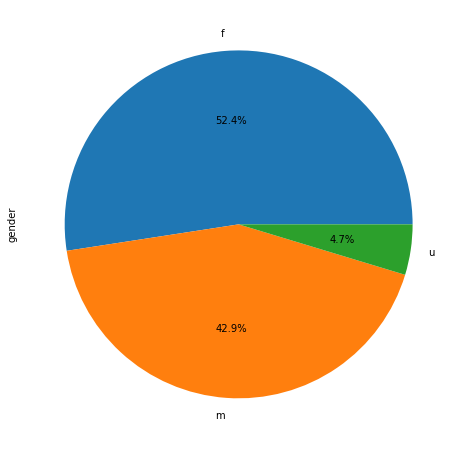

In [12]:
plt.figure(1, figsize=(8,8))
total_data.gender.value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

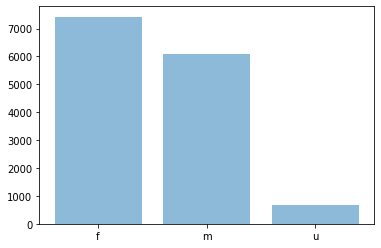

In [13]:
#bar chart
gender = ['f','m','u']
plt.bar(gender, total_data.gender.value_counts(), align='center', alpha=0.5)
plt.show()

m


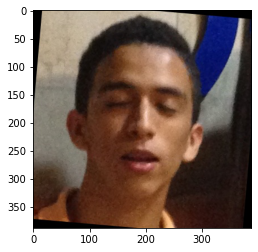

In [14]:
idx = 20
path = "/content/drive/MyDrive/kaggle/AdienceBenchmarkGenderAndAgeClassification/faces/"+total_data.user_id.loc[idx]+"/coarse_tilt_aligned_face."+str(total_data.face_id.loc[idx])+"."+total_data.original_image.loc[idx]
img = load_img(path)
plt.imshow(img)
gender = total_data['gender'][idx]
print(gender)
plt.show()

In [15]:
total_data.gender.value_counts()

f    7424
m    6073
u     663
Name: gender, dtype: int64

In [16]:
df = total_data[['gender']].copy()
df.info()

########
test_l=final_test_data[['gender']].copy()
test_l.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14886 entries, 0 to 14885
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   gender  14160 non-null  object
dtypes: object(1)
memory usage: 116.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4484 entries, 0 to 4483
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   gender  4431 non-null   object
dtypes: object(1)
memory usage: 35.2+ KB


In [17]:

# Adding Path of each Image
img_path = []
for row in total_data.iterrows():
    path = "/content/drive/MyDrive/kaggle/AdienceBenchmarkGenderAndAgeClassification/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)
df['img_path'] = img_path

In [18]:
# Adding Path of each Image in Final test set
img_path2 = []   ################
for row in final_test_data.iterrows():
    path = "/content/drive/MyDrive/kaggle/AdienceBenchmarkGenderAndAgeClassification/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path2.append(path)
test_l['img_path'] = img_path2

In [19]:
# Dropping Null Values
df = df.dropna()
unbiased_data = df[df.gender != 'u'].copy()
unbiased_data.info()
####################################
# Dropping Null Values
test_l = test_l.dropna()
unbiased_data2 = test_l[test_l.gender != 'u'].copy()
unbiased_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13497 entries, 0 to 14861
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   gender    13497 non-null  object
 1   img_path  13497 non-null  object
dtypes: object(2)
memory usage: 316.3+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3995 entries, 0 to 4481
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   gender    3995 non-null   object
 1   img_path  3995 non-null   object
dtypes: object(2)
memory usage: 93.6+ KB


In [20]:
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}


unbiased_data['gender'] = unbiased_data['gender'].apply(lambda g: gender_to_label_map[g])
unbiased_data.head()

#############################
unbiased_data2['gender'] = unbiased_data2['gender'].apply(lambda g: gender_to_label_map[g])
unbiased_data2.head()



,gender,img_path
0,0,/content/drive/MyDrive/kaggle/AdienceBenchmark...
1,1,/content/drive/MyDrive/kaggle/AdienceBenchmark...
2,0,/content/drive/MyDrive/kaggle/AdienceBenchmark...
3,1,/content/drive/MyDrive/kaggle/AdienceBenchmark...
4,1,/content/drive/MyDrive/kaggle/AdienceBenchmark...


In [21]:
# Resizing the images Data of Train data
X = unbiased_data[['img_path']]
y = unbiased_data[['gender']]

train_images = []
for row in X.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((224, 224))   # Resize the image
    data = np.asarray(image)
    train_images.append(data)

train_images = np.asarray(train_images)
print('Train images shape {}'.format(train_images.shape))


Train images shape (13497, 224, 224, 3)


In [22]:
# Resizing the images Data of Train and Test set
X_test = unbiased_data2[['img_path']]
y_test = unbiased_data2[['gender']]

final_test_images = []
for row in X_test.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((224, 224))   # Resize the image
    data = np.asarray(image)
    final_test_images.append(data)

final_test_images = np.asarray(final_test_images)
print('final test images data set shape {}'.format(final_test_images.shape))
#################### final_test_images and y_test are final test data

final test images data set shape (3995, 224, 224, 3)


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import random
import glob
import pandas as pd
import shutil 
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline
from random import randint
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import itertools
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [24]:
print(len(train_images))
print(len(y))

13497
13497


Details of fold  1
Train images shape (10797, 224, 224, 3)
Val images shape (2700, 224, 224, 3)
 Lenght of training label  10797
Length of vaidation label  2700
94773248/94765736 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/2
169/169 [==============================] - 71s 226ms/step - loss: 2.0575 - accuracy: 0.8137 - val_loss: 0.4145 - val_accuracy: 0.8759
Epoch 2/2
169/169 [==============================] - 36s 216ms/step - loss: 0.1868 - accuracy: 0.9385 - val_loss: 0.3242 - val_accuracy: 0.9041


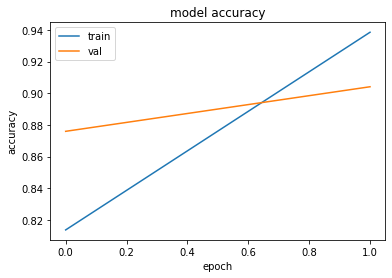

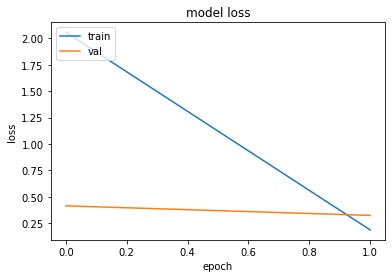

125/125 [==============================] - 12s 96ms/step - loss: 0.5465 - accuracy: 0.8481
Details of fold  2
Train images shape (10797, 224, 224, 3)
Val images shape (2700, 224, 224, 3)
 Lenght of training label  10797
Length of vaidation label  2700


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/2
169/169 [==============================] - 42s 227ms/step - loss: 1.9086 - accuracy: 0.5518 - val_loss: 0.6909 - val_accuracy: 0.5441
Epoch 2/2
169/169 [==============================] - 38s 225ms/step - loss: 0.6462 - accuracy: 0.6491 - val_loss: 0.5261 - val_accuracy: 0.8419


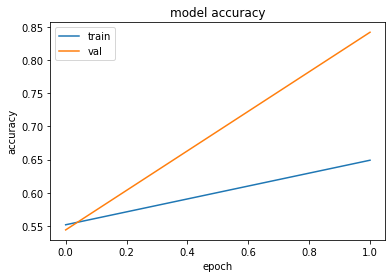

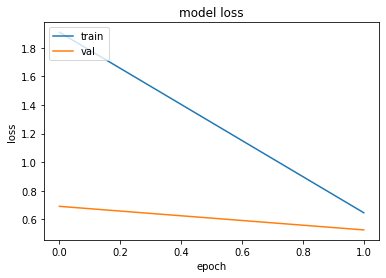

125/125 [==============================] - 12s 93ms/step - loss: 0.5255 - accuracy: 0.8125
Details of fold  3
Train images shape (10798, 224, 224, 3)
Val images shape (2699, 224, 224, 3)
 Lenght of training label  10798
Length of vaidation label  2699


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/2
169/169 [==============================] - 43s 239ms/step - loss: 1.2420 - accuracy: 0.8308 - val_loss: 0.2777 - val_accuracy: 0.8892
Epoch 2/2
169/169 [==============================] - 38s 227ms/step - loss: 0.1143 - accuracy: 0.9590 - val_loss: 0.3832 - val_accuracy: 0.8685


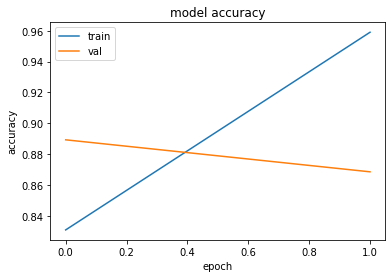

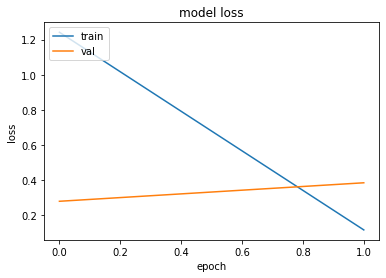

125/125 [==============================] - 12s 93ms/step - loss: 0.5849 - accuracy: 0.8093
Details of fold  4
Train images shape (10798, 224, 224, 3)
Val images shape (2699, 224, 224, 3)
 Lenght of training label  10798
Length of vaidation label  2699


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/2
169/169 [==============================] - 42s 231ms/step - loss: 2.1089 - accuracy: 0.8099 - val_loss: 0.3685 - val_accuracy: 0.8959
Epoch 2/2
169/169 [==============================] - 38s 228ms/step - loss: 0.1525 - accuracy: 0.9492 - val_loss: 0.3579 - val_accuracy: 0.8892


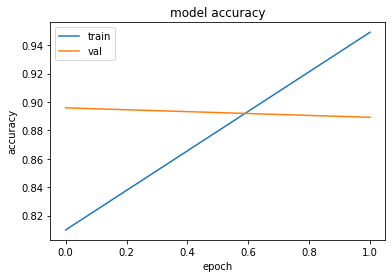

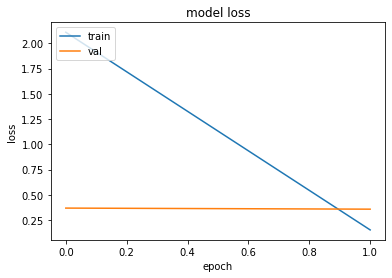

125/125 [==============================] - 12s 94ms/step - loss: 0.6126 - accuracy: 0.8310
Details of fold  5
Train images shape (10798, 224, 224, 3)
Val images shape (2699, 224, 224, 3)
 Lenght of training label  10798
Length of vaidation label  2699


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/2
169/169 [==============================] - 42s 231ms/step - loss: 1.5238 - accuracy: 0.8289 - val_loss: 0.2946 - val_accuracy: 0.8781
Epoch 2/2
169/169 [==============================] - 39s 229ms/step - loss: 0.1218 - accuracy: 0.9569 - val_loss: 0.2750 - val_accuracy: 0.8844


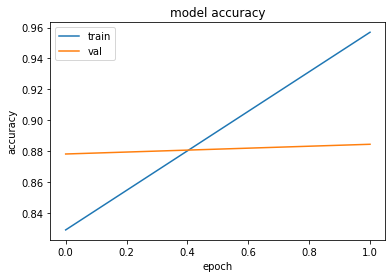

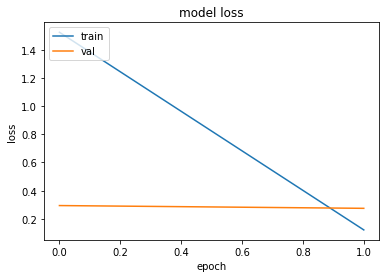

125/125 [==============================] - 12s 95ms/step - loss: 0.4404 - accuracy: 0.8230


In [25]:
from sklearn.model_selection import KFold
skf = KFold(n_splits = 5, random_state = 7, shuffle = True) 

fold = 1
All_train_acc = []
All_val_acc = []
All_test_acc=[]

for train_index, val_index in skf.split(X):
   X_train, X_val = train_images[train_index], train_images[val_index]
   y_train, y_val = y.iloc[train_index], y.iloc[val_index]

   #X_train = X_train/255.0    heavy computation
   #X_val = X_val/255.0

   print("Details of fold ", fold)
   print('Train images shape {}'.format(X_train.shape))
   print('Val images shape {}'.format(X_val.shape))
   print(" Lenght of training label ", len(y_train))
   print("Length of vaidation label ", len(y_val))
   
   restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
   output = restnet.layers[-1].output
   output = keras.layers.Flatten()(output)
   restnet = Model(restnet.input, outputs=output)
   for layer in restnet.layers:
     layer.trainable = False
   #restnet.summary()

   model = Sequential()
   model.add(restnet)
   model.add(Dense(256, activation='relu', input_shape=(224, 224, 3)))
   model.add(Dense(1, activation='sigmoid'))
   model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])
   #model.summary()
   history = model.fit(X_train, y_train, batch_size=64, epochs=2,  validation_data = (X_val, y_val)) 
   plt.plot(history.history['accuracy'])
   plt.plot(history.history['val_accuracy'])
   plt.title('model accuracy')
   plt.ylabel('accuracy')
   plt.xlabel('epoch')
   plt.legend(['train', 'val'], loc='upper left')
   plt.show()

   plt.plot(history.history['loss'])
   plt.plot(history.history['val_loss'])
   plt.title('model loss')
   plt.ylabel('loss')
   plt.xlabel('epoch')
   plt.legend(['train', 'val'], loc='upper left')
   plt.show()

   

   train_acc=model.evaluate(X_train, y_train)
   All_train_acc.append(train_acc)
   val_acc=model.evaluate(X_val, y_val)
   All_val_acc.append(val_acc)
   ##########################  run on final test data
   test_acc=model.evaluate(final_test_images, y_test)
   All_test_acc.append(test_acc)


   fold = fold+1
  


In [26]:
for i in range(len(All_train_acc)):
  print("Training Loss & Accuracy  for fold ", i, "are ", All_train_acc[i][0] ,"      ", All_train_acc[i][1])


for i in range(len(All_val_acc)):
  print("Validation Loss & Accuracy  for fold ", i, "are ", All_val_acc[i][0] ,"      ", All_val_acc[i][1])

######################################
for i in range(len(All_test_acc)):
  print("Final Test data set: Loss & Accuracy  for fold  ", i+1, "are ", All_test_acc[i][0] ,"      ", All_test_acc[i][1])

t=0
for i in range(len(All_test_acc)):
  t=t+All_test_acc[i][1]
print("Mean accuracy of all 5 folds is ", (t/5)*100,"%")


Training Loss & Accuracy  for fold  0 are  0.04144175350666046        0.9856441617012024
Training Loss & Accuracy  for fold  1 are  0.5170910358428955        0.856348991394043
Training Loss & Accuracy  for fold  2 are  0.10774407535791397        0.955732524394989
Training Loss & Accuracy  for fold  3 are  0.0953318253159523        0.9603630304336548
Training Loss & Accuracy  for fold  4 are  0.07733790576457977        0.9791628122329712
Validation Loss & Accuracy  for fold  0 are  0.3241562247276306        0.9040740728378296
Validation Loss & Accuracy  for fold  1 are  0.5260995626449585        0.8418518304824829
Validation Loss & Accuracy  for fold  2 are  0.38321182131767273        0.868469774723053
Validation Loss & Accuracy  for fold  3 are  0.3579002320766449        0.8892182111740112
Validation Loss & Accuracy  for fold  4 are  0.2749544382095337        0.8844016194343567
Final Test data set: Loss & Accuracy  for fold   1 are  0.5464738607406616        0.8480600714683533
Final Te

In [ ]:
# to improve accuracy, increase the epochs, try some other image size, normalize the input, images/=255 